# Hamming weight extractor

- Extracts the Hamming weight of the state after the SBox in the first round.
- Appends a hamming weight column to the ASCAD file.

In [8]:
import os

import h5py
import numpy as np
import seaborn as sns

from src.data.loaders.ascad import ASCADData
from src.data.preprocess.hw import full_states
from src.pollution.desync import desync
from src.pollution.jitter import jitter
from src.tools.lists import find
from src.tools.plotter import init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType, Pollution
from src.trace_set.set_hw import TraceSetHW

init_plots()

In [9]:
ascad = ASCADData.random_key()
plaintext_ix = 0
full_key_ix = 1

profile_metadata = np.array(ascad["Profiling_traces"]["metadata"])
profile_traces = np.array(ascad["Profiling_traces"]["traces"])

attack_metadata = np.array(ascad["Attack_traces"]["metadata"])
attack_traces = np.array(ascad["Attack_traces"]["traces"])

def get_acc(metadata):
    return np.zeros((len(metadata), 16), dtype=np.uint8)

profile_key, profile_plain = get_acc(profile_metadata), get_acc(profile_metadata)
attack_key, attack_plain = get_acc(attack_metadata), get_acc(attack_metadata)

for ix in range(len(profile_metadata)):
    profile_key[ix] = profile_metadata[ix][full_key_ix]
    profile_plain[ix] = profile_metadata[ix][plaintext_ix]

for ix in range(len(attack_metadata)):
    attack_key[ix] = attack_metadata[ix][full_key_ix]
    attack_plain[ix] = attack_metadata[ix][plaintext_ix]

ascad.close()

### Example trace

<AxesSubplot:>

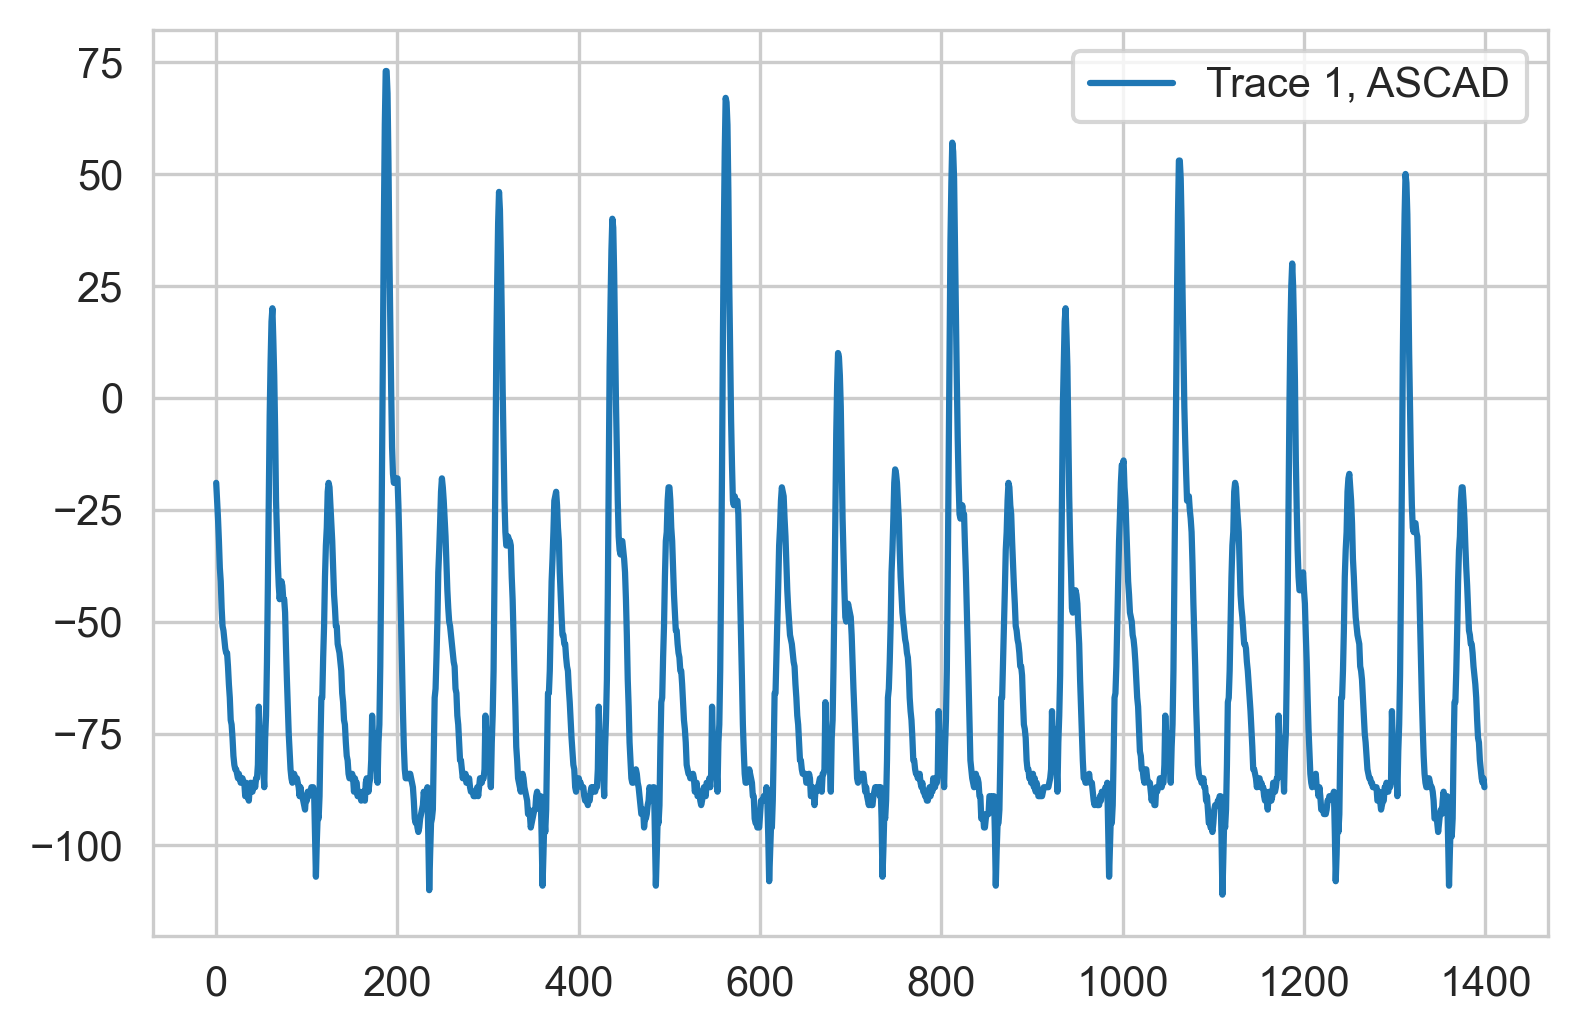

In [10]:
sns.lineplot(data={
    "Trace 1, ASCAD": profile_traces[0]
})

### Calculate full intermediate states from AES

Based on plaintext and key metadata.

In [11]:
profile_hw = full_states(profile_plain, profile_key)
attack_hw = full_states(attack_plain, attack_key)

100%|██████████| 100000/100000 [00:31<00:00, 3202.54it/s]


### Hamming Weights of the first byte of the first state.

In [12]:
profile_hw_00 = profile_hw[:, 0, 2]
attack_hw_00 = attack_hw[:, 0, 2]

<AxesSubplot:>

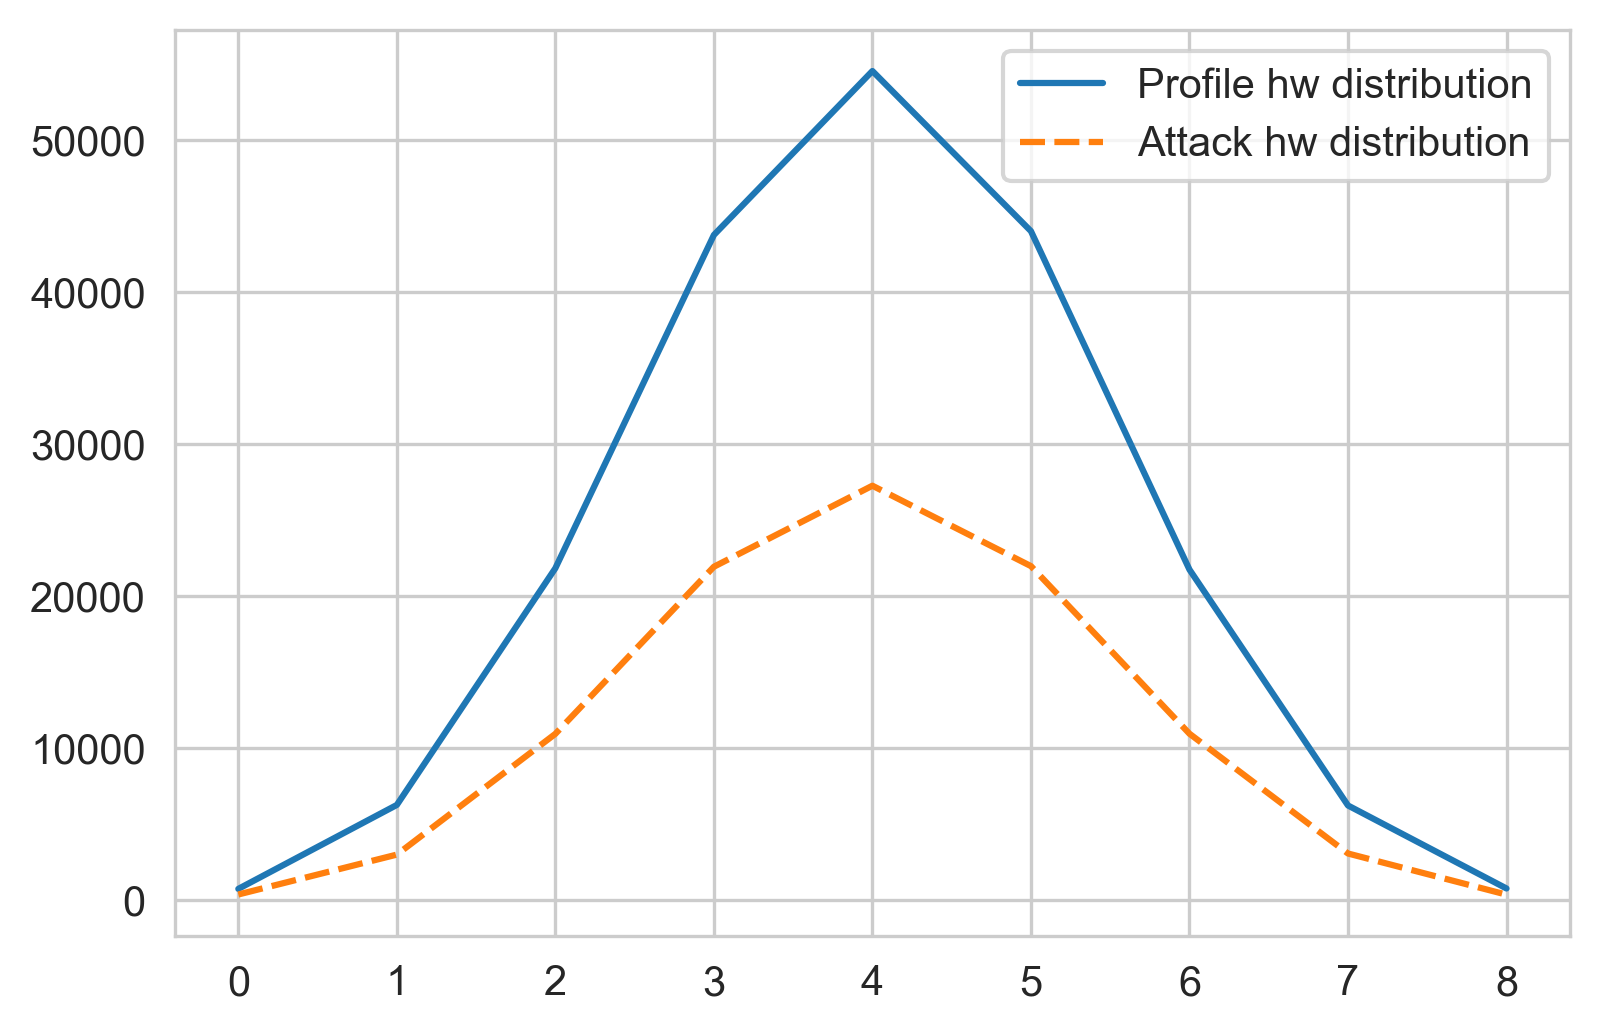

In [13]:
sns.lineplot(data={
    "Profile hw distribution": np.bincount(profile_hw_00),
    "Attack hw distribution": np.bincount(attack_hw_00),
})

### Create default traceset

In [14]:
TraceSetHW(Database.ascad).create(
    profile_traces, profile_hw_00, attack_traces, attack_hw_00
)

In [15]:
ascad = TraceSetHW(Database.ascad).open('r')
print(ascad['attack/hw'])
ascad.close()

<HDF5 dataset "hw": shape (100000,), type "|u1">


In [25]:
JITTER_PARAMS = np.arange(.75, 10.25, .25)

for param in JITTER_PARAMS:
    pollution = Pollution(PollutionType.jitter, param)
    out = TraceSetHW(Database.ascad, pollution)

    if not os.path.exists(out.path):
        profile_jitter = jitter(profile_traces, param)
        attack_jitter = jitter(attack_traces, param)

        out.create(profile_jitter, profile_hw_00, attack_jitter, attack_hw_00)

Applying jitter with exp=10.0: 100%|██████████| 100000/100000 [02:53<00:00, 577.38it/s]


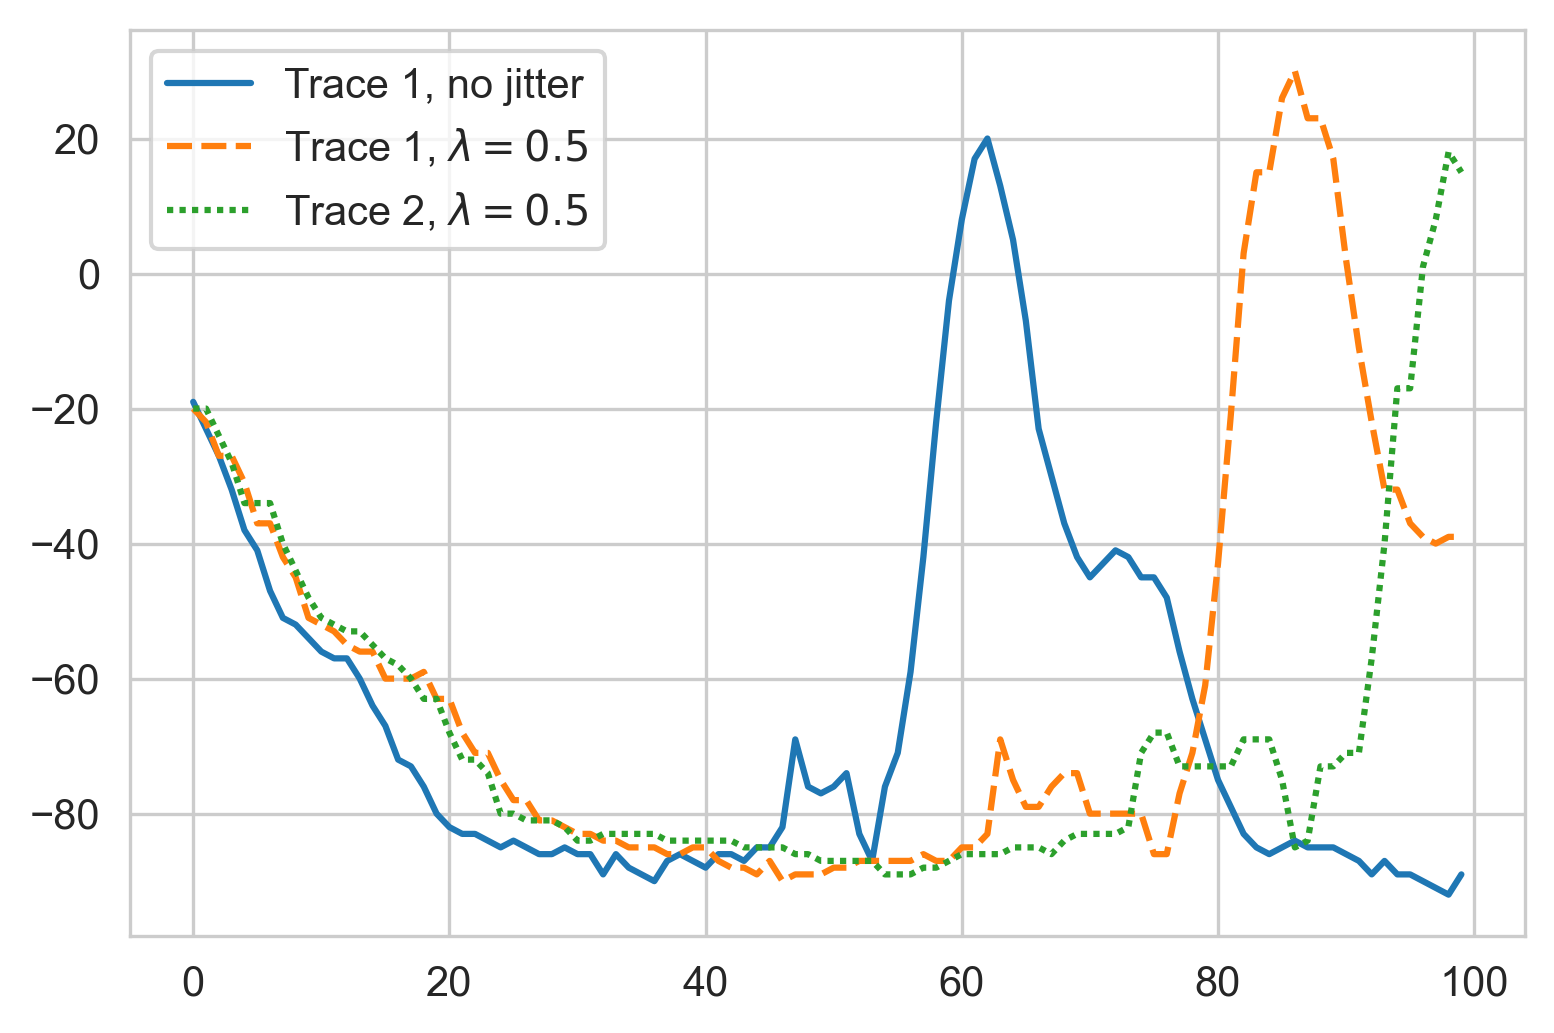

In [17]:
EXAMPLE = TraceSetHW(Database.ascad, Pollution(PollutionType.jitter, 1))
f = EXAMPLE.open('r')

sns.lineplot(data={
    "Trace 1, no jitter": profile_traces[0, :100],
    "Trace 1, $\lambda = 0.5$": np.array(f["profile"]["traces"])[0, :100],
    "Trace 2, $\lambda = 0.5$": np.array(f["profile"]["traces"])[1, :100],
})

EXAMPLE.close()

## Trace desynchronization

In [18]:
RAW = h5py.File(f"/data/ASCAD/ATMEGA_AES_v1/ASCAD_data/ASCAD_databases/atmega8515-raw-traces.h5", 'r')

In [19]:
raw_traces = RAW['traces']

trace_ix = find(raw_traces[0], profile_traces[0])
print(trace_ix)

80945


In [20]:
profiling_mask = np.ones(len(raw_traces)).astype(bool)
profiling_mask[2::3] = False

# Remove last trace, as last raw trace does not correspond to any attack or profiling trace.
profiling_mask = profiling_mask[:-1]

assert find(raw_traces[-3], profile_traces[-1]) == trace_ix
assert find(raw_traces[-2], attack_traces[-1]) == trace_ix

In [29]:
# DESYNC_PARAMS = np.arange(50, 350, 50)
DESYNC_PARAMS = np.arange(2, 10, 2)
DESYNC_PARAMS

array([2, 4, 6, 8])

In [30]:
for param in DESYNC_PARAMS:
    pollution = Pollution(PollutionType.desync, param)
    out = TraceSetHW(Database.ascad, pollution)

    if not os.path.exists(out.path):
        profile_desync, attack_desync = desync(param, raw_traces, profiling_mask, profile_traces, attack_traces)
        out.create(profile_desync, profile_hw_00, attack_desync, attack_hw_00)

Trace desynchronization, sigma=8: 100%|██████████| 300000/300000 [07:08<00:00, 700.06it/s]


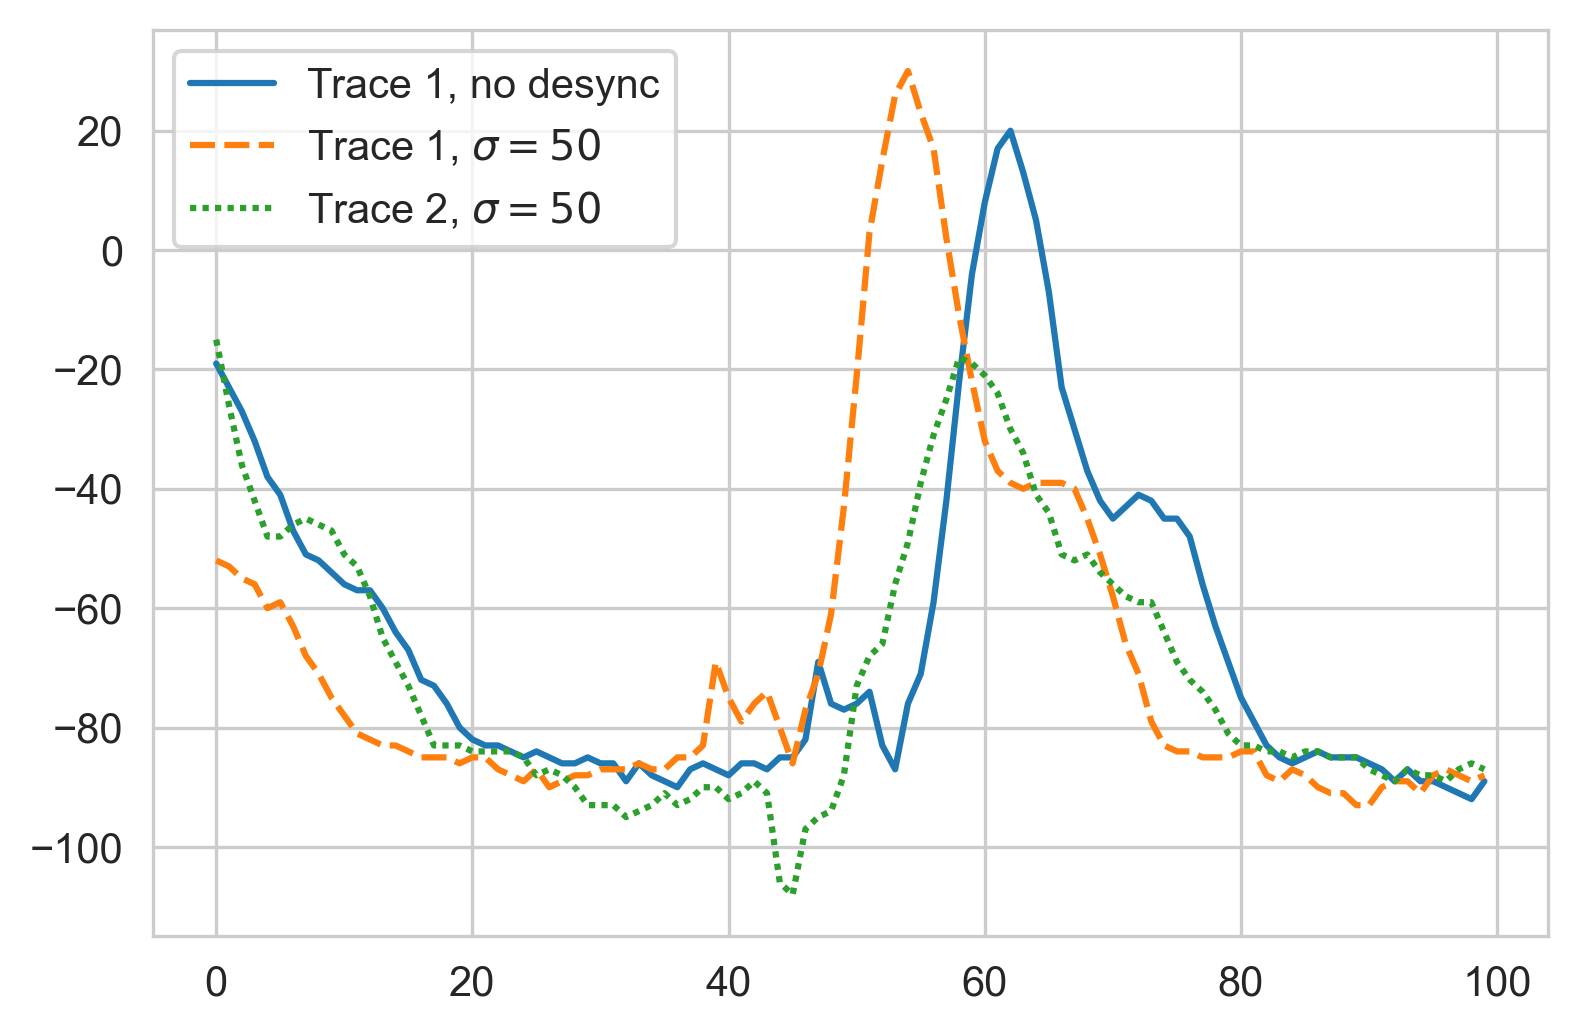

In [22]:
EXAMPLE = TraceSetHW(Database.ascad, Pollution(PollutionType.desync, 50))
f = EXAMPLE.open('r')

sns.lineplot(data={
    "Trace 1, no desync": profile_traces[0, :100],
    "Trace 1, $\sigma = 50$": np.array(f["profile"]["traces"])[0, :100],
    "Trace 2, $\sigma = 50$": np.array(f["profile"]["traces"])[1, :100],
})

EXAMPLE.close()